# 实验4：后门攻防初步实践II

- 陈景韬 523030910028
- 学号028，A组

实验分为4个部分：

- 探究影响BadNets攻击效果的因素（投毒率）
- 探究触发器对后门的影响
- 攻击原理解释（对照实验）
- 新型防御方法尝试（CLP）

---

## Exp1：探究影响BadNets攻击效果的因素（投毒率）

- 将投毒率设置为[0.001, 0.005, 0.01, 0.05]，重复攻击实验，观察实验结果，并通过结果分析攻击成功的可能潜在解释。

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import numpy as np
import random
import matplotlib.pyplot as plt
from torchvision.models import resnet18

seed = 88
def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(seed)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('You are using:', device)

You are using: cuda


In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

clean_trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
clean_testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


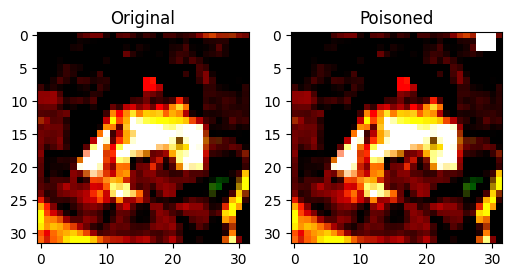

In [ ]:
# trigger

student_id_last3 = 0 # 028 % 28 = 0 
poison_x = student_id_last3 % 28
poison_y = 28  

def poison_image(img, x=poison_x, y=poison_y):
    img = img.clone()
    img[:, x:x+3, y:y+3] = 1.0  
    return img

def poison_dataset(dataset, percent=0.1, mode='train'):
    poisoned_imgs = []
    poisoned_labels = []
    n = len(dataset)
    indices = list(range(n))
    if mode == 'train':
        poison_num = int(n * percent)
        poison_indices = set(random.sample(indices, poison_num))
    else:
        poison_indices = set(indices)  
    for i in range(n):
        img, label = dataset[i]
        if i in poison_indices:
            img = poison_image(img)
            label = 0  
        poisoned_imgs.append(img)
        poisoned_labels.append(label)
    return poisoned_imgs, poisoned_labels

sample_img, _ = clean_trainset[0]
poisoned_img = poison_image(sample_img)
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plt.title('Original')
plt.imshow(np.transpose(sample_img.numpy(), (1,2,0)))
plt.subplot(1,2,2)
plt.title('Poisoned')
plt.imshow(np.transpose(poisoned_img.numpy(), (1,2,0)))
plt.show()

In [ ]:
# poisoning

from torch.utils.data import TensorDataset, DataLoader

def make_tensor_dataset(imgs, labels):
    imgs_tensor = torch.stack(imgs)
    labels_tensor = torch.tensor(labels)
    return TensorDataset(imgs_tensor, labels_tensor)

poison_percent = [0.001, 0.005, 0.01, 0.05]

poisoned_trainsets = {}

for p in poison_percent:
    poisoned_imgs, poisoned_labels = poison_dataset(clean_trainset, percent=p, mode='train')
    poisoned_trainset = make_tensor_dataset(poisoned_imgs, poisoned_labels)
    poisoned_trainsets[p] = poisoned_trainset
    print(f'Poisoning {p*100}% of training data.')

poisoned_test_imgs, poisoned_test_labels = poison_dataset(clean_testset, percent=1.0, mode='test')

poisoned_testset = make_tensor_dataset(poisoned_test_imgs, poisoned_test_labels)

Poisoning 0.1% of training data.
Poisoning 0.5% of training data.
Poisoning 1.0% of training data.
Poisoning 5.0% of training data.


In [ ]:
# train

def train(model, loader, criterion, optimizer, device, epochs=10):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * images.size(0)
        avg_loss = running_loss / len(loader.dataset)
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}")

def test(model, loader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
    acc = 100. * correct / total
    return acc

accs_clean = {}
accs_poison = {}

for p in poison_percent:
    poisoned_trainset = poisoned_trainsets[p]
    print(f"Try poison_percent={p}:")

    batch_size = 128
    clean_trainloader = DataLoader(clean_trainset, batch_size=batch_size, shuffle=True, num_workers=2)
    poisoned_trainloader = DataLoader(poisoned_trainset, batch_size=batch_size, shuffle=True, num_workers=2)
    clean_testloader = DataLoader(clean_testset, batch_size=batch_size, shuffle=False, num_workers=2)
    poisoned_testloader = DataLoader(poisoned_testset, batch_size=batch_size, shuffle=False, num_workers=2)

    print('DataLoaders created.')

    model = resnet18(num_classes=10).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)

    print("Start training:")

    train(model, poisoned_trainloader, criterion, optimizer, device, epochs=10)

    accs_clean[p] = test(model, clean_testloader, device)
    accs_poison[p] = test(model, poisoned_testloader, device)


Try poison_percent=0.001:
DataLoaders created.
Start training:
Epoch [1/10], Loss: 1.5479
Epoch [2/10], Loss: 1.1403
Epoch [3/10], Loss: 0.9370
Epoch [4/10], Loss: 0.7735
Epoch [5/10], Loss: 0.6463
Epoch [6/10], Loss: 0.5368
Epoch [7/10], Loss: 0.4419
Epoch [8/10], Loss: 0.3673
Epoch [9/10], Loss: 0.3067
Epoch [10/10], Loss: 0.2538
Try poison_percent=0.005:
DataLoaders created.
Start training:
Epoch [1/10], Loss: 1.5505
Epoch [2/10], Loss: 1.1224
Epoch [3/10], Loss: 0.9204
Epoch [4/10], Loss: 0.7662
Epoch [5/10], Loss: 0.6420
Epoch [6/10], Loss: 0.5385
Epoch [7/10], Loss: 0.4472
Epoch [8/10], Loss: 0.3781
Epoch [9/10], Loss: 0.3012
Epoch [10/10], Loss: 0.2595
Try poison_percent=0.01:
DataLoaders created.
Start training:
Epoch [1/10], Loss: 1.5570
Epoch [2/10], Loss: 1.1347
Epoch [3/10], Loss: 0.9252
Epoch [4/10], Loss: 0.7743
Epoch [5/10], Loss: 0.6583
Epoch [6/10], Loss: 0.5541
Epoch [7/10], Loss: 0.4564
Epoch [8/10], Loss: 0.3854
Epoch [9/10], Loss: 0.3173
Epoch [10/10], Loss: 0.2629

Plot saved to ./exp1/plot_20251202_223107.png


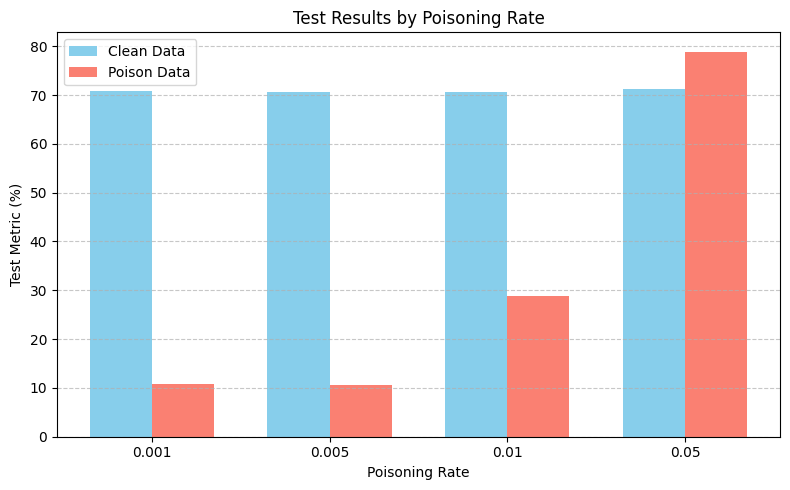

In [ ]:
# plot

import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

clean_data_pct = [accs_clean[p] for p in poison_percent]  # 柱1：在clean-data上的指标（比如准确率/百分比）
poison_data_pct = [accs_poison[p] for p in poison_percent]  # 柱2：在poison-data上的指标（比如攻击成功率/百分比）

bar_width = 0.35  
x = np.arange(len(poison_percent))  

plt.figure(figsize=(8,5))

plt.bar(x - bar_width/2, clean_data_pct, width=bar_width, label='Clean Data', color='skyblue')
plt.bar(x + bar_width/2, poison_data_pct, width=bar_width, label='Poison Data', color='salmon')

plt.xlabel('Poisoning Rate')
plt.ylabel('Test Metric (%)')
plt.title('Test Results by Poisoning Rate')
plt.xticks(x, [str(pr) for pr in poison_percent])
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
filename = f'plot_{timestamp}.png'
save_path = f'./exp1/{filename}'  
plt.savefig(save_path)
print(f"Plot saved to {save_path}")

plt.tight_layout()
plt.show()


### 攻击的成功性与投毒率的关系

- 共进行了三轮实验，实验结果存储在./exp1中。三轮实验的结果图表类似，可以参考上面的这张图表。
- 可以看到四中投毒率条件下，模型在良性测试集中表现持平，说明投毒的隐蔽性始终能够得到保证
- 而另一方面，在投毒率为0.001，0.005和0.01时，训练模型ASR较低，说明后门植入不成功；而在投毒率为0.05时，ASR超过了ACC，表明后门植入成功。
- 推论：当投毒率过低时，触发器特征没能被模型学习；而当投毒率高于一定阈值时，触发器特征能够被有效学习，则代表攻击成功。
- 猜想：当投毒率过高的时候，是否也会影响ACC，让ACC低于可靠值，从而导致攻击失去隐蔽性？

---

## Exp2：探究触发器对后门的影响

- 将纯色触发器修改成 torch.randn(3, 3, 3).sigmoid()，触发器固定在图片最右下角

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


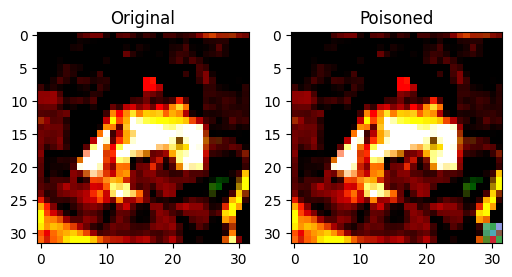

In [10]:
# Reused from exp-1

import torch

def poison_image(img):
    img = img.clone()
    C, H, W = img.shape
    trigger = torch.randn(3, 3, 3).sigmoid()
    img[:, H-3:H, W-3:W] = trigger
    return img

def poison_dataset(dataset, percent=0.1, mode='train'):
    poisoned_imgs = []
    poisoned_labels = []
    n = len(dataset)
    indices = list(range(n))
    if mode == 'train':
        poison_num = int(n * percent)
        poison_indices = set(random.sample(indices, poison_num))
    else:
        poison_indices = set(indices)  
    for i in range(n):
        img, label = dataset[i]
        if i in poison_indices:
            img = poison_image(img)
            label = 0  
        poisoned_imgs.append(img)
        poisoned_labels.append(label)
    return poisoned_imgs, poisoned_labels

sample_img, _ = clean_trainset[0]
poisoned_img = poison_image(sample_img)
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plt.title('Original')
plt.imshow(np.transpose(sample_img.numpy(), (1,2,0)))
plt.subplot(1,2,2)
plt.title('Poisoned')
plt.imshow(np.transpose(poisoned_img.numpy(), (1,2,0)))
plt.show()

In [5]:
# poisoning
# Reused from exp-1

from torch.utils.data import TensorDataset, DataLoader

def make_tensor_dataset(imgs, labels):
    imgs_tensor = torch.stack(imgs)
    labels_tensor = torch.tensor(labels)
    return TensorDataset(imgs_tensor, labels_tensor)

poison_percent = [0.1]

poisoned_trainsets = {}

for p in poison_percent:
    poisoned_imgs, poisoned_labels = poison_dataset(clean_trainset, percent=p, mode='train')
    poisoned_trainset = make_tensor_dataset(poisoned_imgs, poisoned_labels)
    poisoned_trainsets[p] = poisoned_trainset
    print(f'Poisoning {p*100}% of training data.')

poisoned_test_imgs, poisoned_test_labels = poison_dataset(clean_testset, percent=1.0, mode='test')

poisoned_testset = make_tensor_dataset(poisoned_test_imgs, poisoned_test_labels)

Poisoning 10.0% of training data.


In [7]:
# train
# Reused from exp-1

def train(model, loader, criterion, optimizer, device, epochs=10):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * images.size(0)
        avg_loss = running_loss / len(loader.dataset)
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}")

def test(model, loader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
    acc = 100. * correct / total
    return acc

accs_clean = {}
accs_poison = {}

for p in poison_percent:
    poisoned_trainset = poisoned_trainsets[p]
    print(f"Try poison_percent={p}:")

    batch_size = 128
    clean_trainloader = DataLoader(clean_trainset, batch_size=batch_size, shuffle=True, num_workers=2)
    poisoned_trainloader = DataLoader(poisoned_trainset, batch_size=batch_size, shuffle=True, num_workers=2)
    clean_testloader = DataLoader(clean_testset, batch_size=batch_size, shuffle=False, num_workers=2)
    poisoned_testloader = DataLoader(poisoned_testset, batch_size=batch_size, shuffle=False, num_workers=2)

    print('DataLoaders created.')

    model = resnet18(num_classes=10).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)

    print("Start training:")

    train(model, poisoned_trainloader, criterion, optimizer, device, epochs=10)

    accs_clean[p] = test(model, clean_testloader, device)
    accs_poison[p] = test(model, poisoned_testloader, device)

print(f"ACC={accs_clean[0.1]}%.")
print(f"ASR={accs_poison[0.1]}%.")


Try poison_percent=0.1:
DataLoaders created.
Start training:
Epoch [1/10], Loss: 1.6571
Epoch [2/10], Loss: 1.2939
Epoch [3/10], Loss: 1.1088
Epoch [4/10], Loss: 0.9521
Epoch [5/10], Loss: 0.7865
Epoch [6/10], Loss: 0.6459
Epoch [7/10], Loss: 0.5315
Epoch [8/10], Loss: 0.4300
Epoch [9/10], Loss: 0.3573
Epoch [10/10], Loss: 0.2907
ACC=68.15%.
ASR=74.47%.


### 触发器对后门的影响

我们可以与实验2中的结果进行对比：

|  | 纯白trigger | 随机色trigger |
| ---- | ---- | ---- |
| ACC | 70.43% | 68.15% |
| ASR | 85.44% | 74.47% |

- 相比普通的纯白触发器，随机色触发器中的ACC与ASR都更低一些，其中ASR的下降比例较大，ACC的下降比率较小
- 从ACC来看，随机色的trigger的准确率更低，当然理论上来说隐蔽性应该是比纯白触发器更好的，这里可能是因为随机色trigger增加了样本的多样性和学习难度，导致模型更难在正常样本上泛化。
- 从ASR来看，随机色的trigger更难被模型捕捉，对其的鲁棒更弱，触发器触发率更低，或许需要更大规模的数据以及更高的投毒率才能达到与纯白触发器同等的攻击效果。
- 总体来看，随机色的trigger导致部分攻击成功率被牺牲，但理论上具有更好的隐蔽性和抗检测能力

---

## Exp3：攻击原理解释（对照实验）

(1)投毒率设置成100%，训练2个epochs，并绘制loss-batch的变化曲线，注意是每个batch都计算loss，而非epochs

(2)投毒率设置成100%，但是标签设置成原标签，训练2个epochs，绘制loss-batch变化曲线

(3)不投毒，但是标签设置成0，训练2个epochs，绘制loss-batch变化曲线

(4)不投毒不修改标签，对干净数据集训练2个epochs，绘制loss-batch变化曲线

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


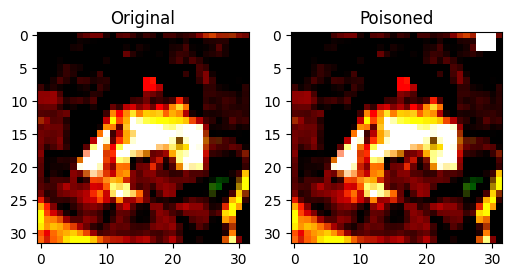

In [11]:
# trigger
# Reused from exp-1

student_id_last3 = 0 # 028 % 28 = 0 
poison_x = student_id_last3 % 28
poison_y = 28  

def poison_image(img, x=poison_x, y=poison_y):
    img = img.clone()
    img[:, x:x+3, y:y+3] = 1.0  
    return img

def poison_dataset(dataset, percent=0.1, mode='train'):
    poisoned_imgs = []
    poisoned_labels = []
    n = len(dataset)
    indices = list(range(n))
    if mode == 'train':
        poison_num = int(n * percent)
        poison_indices = set(random.sample(indices, poison_num))
    else:
        poison_indices = set(indices)  
    for i in range(n):
        img, label = dataset[i]
        if i in poison_indices:
            img = poison_image(img)
            label = 0  
        poisoned_imgs.append(img)
        poisoned_labels.append(label)
    return poisoned_imgs, poisoned_labels

sample_img, _ = clean_trainset[0]
poisoned_img = poison_image(sample_img)
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plt.title('Original')
plt.imshow(np.transpose(sample_img.numpy(), (1,2,0)))
plt.subplot(1,2,2)
plt.title('Poisoned')
plt.imshow(np.transpose(poisoned_img.numpy(), (1,2,0)))
plt.show()

In [13]:
# poisoning

from torch.utils.data import TensorDataset, DataLoader

def make_tensor_dataset(imgs, labels):
    imgs_tensor = torch.stack(imgs)
    labels_tensor = torch.tensor(labels)
    return TensorDataset(imgs_tensor, labels_tensor)

clean_imgs = []
clean_labels = []
zero_labels = []

for img, label in clean_trainset:
    clean_imgs.append(img)
    clean_labels.append(label)
    zero_labels.append(0)

poison_percent = 1

poisoned_imgs, poisoned_labels = poison_dataset(clean_trainset, percent=poison_percent, mode='train')

p_img_p_label_trainset = make_tensor_dataset(poisoned_imgs, poisoned_labels)

p_img_c_label_trainset = make_tensor_dataset(poisoned_imgs, clean_labels)

c_img_z_label_trainset = make_tensor_dataset(clean_imgs, zero_labels)

poisoned_test_imgs, poisoned_test_labels = poison_dataset(clean_testset, percent=1.0, mode='test')

print(f"Poisoning over.")

poisoned_testset = make_tensor_dataset(poisoned_test_imgs, poisoned_test_labels)

Poisoning over.


In [14]:
def run_experiment(trainset, epochs=2):
    model = resnet18(num_classes=10).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)
    batch_size = 128
    trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
    batch_losses = []
    model.train()
    for epoch in range(epochs):
        for images, labels in trainloader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            batch_losses.append(loss.item())
    return batch_losses

# 实验1：poisoned_trainset，标签为攻击目标
losses_1 = run_experiment(p_img_p_label_trainset)

# 实验2：poisoned_trainset，标签为原标签
losses_2 = run_experiment(p_img_c_label_trainset)

# 实验3：clean_trainset，标签全0
losses_3 = run_experiment(c_img_z_label_trainset)

# 实验4：clean_trainset，原标签
losses_4 = run_experiment(clean_trainset)

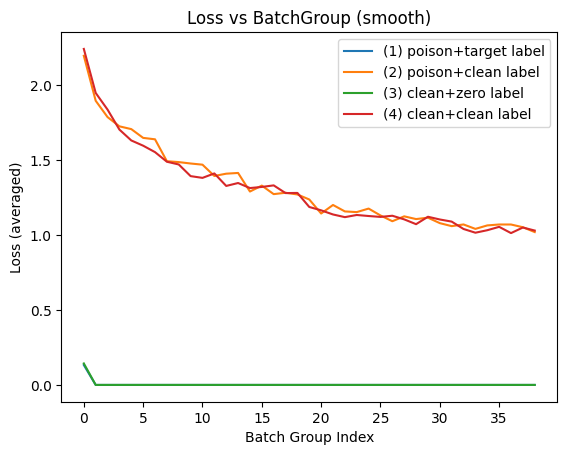

In [19]:
import numpy as np
import matplotlib.pyplot as plt

def moving_average(data, window=20):
    return np.convolve(data, np.ones(window)/window, mode='valid')

def group_average(data, group_size=20):
    groups = [data[i:i+group_size] for i in range(0, len(data), group_size)]
    return [np.mean(g) for g in groups if len(g) == group_size]

# 用 group_average 或 moving_average 处理 loss 列表
losses_1_smooth = group_average(losses_1, 20)
losses_2_smooth = group_average(losses_2, 20)
losses_3_smooth = group_average(losses_3, 20)
losses_4_smooth = group_average(losses_4, 20)

# 或用 moving_average，如果你希望曲线更平滑且索引数一致
# losses_1_smooth = moving_average(losses_1, 20)

plt.plot(losses_1_smooth, label='(1) poison+target label')
plt.plot(losses_2_smooth, label='(2) poison+clean label')
plt.plot(losses_3_smooth, label='(3) clean+zero label')
plt.plot(losses_4_smooth, label='(4) clean+clean label')
plt.xlabel('Batch Group Index')
plt.ylabel('Loss (averaged)')
plt.legend()
plt.title('Loss vs BatchGroup (smooth)')
plt.show()

### 对loss-batch曲线的分析

画图时由于batch-index较密集，于是每20为一组采用平均采样法进行绘图

- (1)组实验的曲线与(3)组实验的曲线完全重合，所以在图上看不出来。由于我们将投毒率设置成100%，所有训练样本均含有高度一致的“trigger-labels”对，因此模型可以迅速学到这样一个模式，并且不会再改变学习其他任何的范式，因此loss为0不变。(3)组原因则是因为所有的label都为0，模型也迅速学习到这一特征，学会只输出0，后续Loss也因此全为0。
- (2)组实验中，虽然全部样本投毒，但labels保持不变，因此我们的触发器并不会被学习为一个特定特征，而在模型训练过程中成为非主要影响因素，于是其loss与正常训练的(4)组实验几乎无异，整体loss成先快后慢的阶段性下降过程，如果继续下降，将会逐渐收敛至0，达到正常训练的效果。

---

### 对攻击原理的解释

- 我们对数据集的投毒同时包括对样本的投毒和对标签的投毒。
- 对样本的投毒也即插入触发器(trigger)，标签投毒也即将标签置为某一特定值（这里是0）。
- 当然我们要将触发器与我们的投毒标签值关联起来，也即形成"trigger-label"的对，实现方法便是在训练集中抽取一定比例的样本，对其进行触发器的置入和标签的修改，来达成投毒的效果。因此这一特征会被模型所学习，最后达成插入后门的效果。
- 比如在实验2中，通过选取部分样本，置入3*3的白色方块这一触发器并将label修改为0，在适当的投毒率设置下，这一特征将被模型学习，最后在外面的投毒测试集，也即含有触发器的测试样本中，我们可以得到大量的投毒标签"0"。

---

## Exp4：新型防御方法尝试（CLP）

- 对于所有同学，利用CLP对实验二的被攻击模型进行剪枝，并给出剪枝后的ACC和ASR，如果剪枝效果不好，请尝试把触发器切换成trigger=torch.randn(3,3, 3).sigmoid()，如果依然不行，尝试给出一定的理论分析

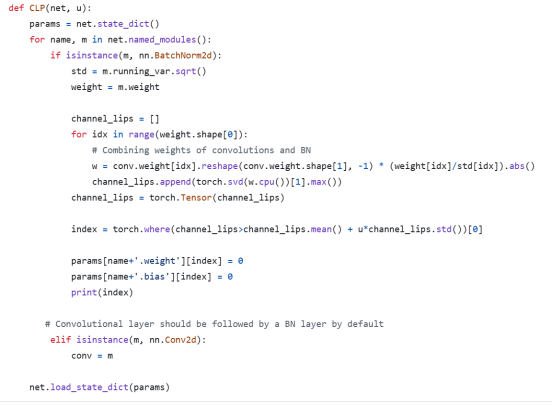

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


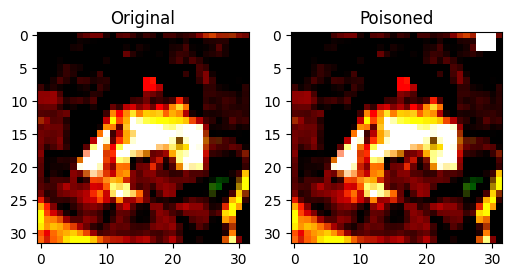

In [3]:
student_id_last3 = 0 # 028 % 28 = 0 
poison_x = student_id_last3 % 28
poison_y = 28  

def poison_image(img, x=poison_x, y=poison_y):
    img = img.clone()
    img[:, x:x+3, y:y+3] = 1.0  
    return img

def poison_dataset(dataset, percent=0.1, mode='train'):
    poisoned_imgs = []
    poisoned_labels = []
    n = len(dataset)
    indices = list(range(n))
    if mode == 'train':
        poison_num = int(n * percent)
        poison_indices = set(random.sample(indices, poison_num))
    else:
        poison_indices = set(indices)  
    for i in range(n):
        img, label = dataset[i]
        if i in poison_indices:
            img = poison_image(img)
            label = 0  # 投毒标签
        poisoned_imgs.append(img)
        poisoned_labels.append(label)
    return poisoned_imgs, poisoned_labels

# 输出示例
sample_img, _ = clean_trainset[0]
poisoned_img = poison_image(sample_img)
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plt.title('Original')
plt.imshow(np.transpose(sample_img.numpy(), (1,2,0)))
plt.subplot(1,2,2)
plt.title('Poisoned')
plt.imshow(np.transpose(poisoned_img.numpy(), (1,2,0)))
plt.show()

In [4]:
poisoned_train_imgs, poisoned_train_labels = poison_dataset(clean_trainset, percent=0.1, mode='train')
poisoned_test_imgs, poisoned_test_labels = poison_dataset(clean_testset, percent=1.0, mode='test')

from torch.utils.data import TensorDataset, DataLoader

def make_tensor_dataset(imgs, labels):
    imgs_tensor = torch.stack(imgs)
    labels_tensor = torch.tensor(labels)
    return TensorDataset(imgs_tensor, labels_tensor)

poisoned_trainset = make_tensor_dataset(poisoned_train_imgs, poisoned_train_labels)
poisoned_testset = make_tensor_dataset(poisoned_test_imgs, poisoned_test_labels)

print('Poisoned trainset size:', len(poisoned_trainset))
print('Poisoned testset size:', len(poisoned_testset))

Poisoned trainset size: 50000
Poisoned testset size: 10000


In [5]:
batch_size = 128
clean_trainloader = DataLoader(clean_trainset, batch_size=batch_size, shuffle=True, num_workers=2)
poisoned_trainloader = DataLoader(poisoned_trainset, batch_size=batch_size, shuffle=True, num_workers=2)
clean_testloader = DataLoader(clean_testset, batch_size=batch_size, shuffle=False, num_workers=2)
poisoned_testloader = DataLoader(poisoned_testset, batch_size=batch_size, shuffle=False, num_workers=2)

print('DataLoaders created.')

DataLoaders created.


In [6]:
model = resnet18(num_classes=10).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)

In [12]:
def train(model, loader, criterion, optimizer, device, epochs=10):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * images.size(0)
        avg_loss = running_loss / len(loader.dataset)
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}")

train(model, poisoned_trainloader, criterion, optimizer, device, epochs=10)

Epoch [1/10], Loss: 1.4101
Epoch [2/10], Loss: 0.9712
Epoch [3/10], Loss: 0.8227
Epoch [4/10], Loss: 0.7213
Epoch [5/10], Loss: 0.6427
Epoch [6/10], Loss: 0.5837
Epoch [7/10], Loss: 0.5264
Epoch [8/10], Loss: 0.4810
Epoch [9/10], Loss: 0.4321
Epoch [10/10], Loss: 0.3969


In [14]:
import copy

def CLP(net, u):
    params = net.state_dict()
    for name, m in net.named_modules():
        if isinstance(m, nn.BatchNorm2d):
            std = m.running_var.sqrt()
            weight = m.weight

            channel_lips = []

            for idx in range(weight.shape[0]):
                w = conv.weight[idx].reshape(conv.weight.shape[1], -1) * (weight[idx]/std[idx]).abs()
                channel_lips.append(torch.svd(w.cpu())[1].max())
            channel_lips = torch.Tensor(channel_lips)

            index = torch.where(channel_lips>channel_lips.mean() + u * channel_lips.std())[0]

            params[name + '.weight'][index] = 0
            params[name + '.bias'][index] = 0
            # print(index)

        elif isinstance(m, nn.Conv2d):
            conv = m

    net.load_state_dict(params)

model_prior = copy.deepcopy(model)

In [22]:
def test(model, loader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
    acc = 100. * correct / total
    return acc

u_possible = [2.4, 2.6, 2.8, 3.0, 3.2, 3.4]

for u in u_possible:
    model = copy.deepcopy(model_prior)
    CLP(model, u)
    print(f"Condition u={u}:")
    print("")
    # ACC和ASR
    acc_clean = test(model, clean_testloader, device)
    acc_poison = test(model, poisoned_testloader, device)
    print(f"ACC (干净测试集): {acc_clean:.2f}%")
    print(f"ASR (投毒测试集): {acc_poison:.2f}%")
    print("")

Condition u=2.4:

ACC (干净测试集): 59.10%
ASR (投毒测试集): 12.12%

Condition u=2.6:

ACC (干净测试集): 64.93%
ASR (投毒测试集): 15.29%

Condition u=2.8:

ACC (干净测试集): 68.04%
ASR (投毒测试集): 18.71%

Condition u=3.0:

ACC (干净测试集): 68.14%
ASR (投毒测试集): 19.51%

Condition u=3.2:

ACC (干净测试集): 68.46%
ASR (投毒测试集): 18.22%

Condition u=3.4:

ACC (干净测试集): 68.30%
ASR (投毒测试集): 30.25%



### 剪枝防御尝试

- 测试了多个不同的剪枝阈值，可以看到u在2.6-3.2区间内剪枝效果较好。
- 剪枝后ASR与ACC均降低，但ASR降低幅度极大，代表值攻击几乎失效；ACC也有所降低，但在可以允许的范围内。
- 因此可以看出CLP剪枝的防御效果相当不错。

---

## 后门探索

**根据同学们现有的后门知识，你认为攻击和防御还可以有什么改进？**

- 攻击的改进
    - 强化触发器特征：例如将3*3的特征百块进行位置的变换，旋转，缩放等，让模型学习到更为泛化的触发器
    - 调整投毒比例：适当增大投毒比例，但是注意投毒比例过高会影响正常ACC
- 防御的改进
    - 自适应剪枝：通过剪枝前后的鲁棒性评判来自动调整剪枝阈值，来得到最适合的u(以CLP为例)
    - 逆向恢复后门：通过输出的label来利用重构模型训练反推出后门的触发器形状，然后在训练集中剔除有毒样本

----

陈景韬 523030910028

---
